<a href="https://colab.research.google.com/github/iru99/breast-cancer-decision-support-pytorch/blob/main/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Breast_Cancer_Dataset**

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve, auc
)

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [2]:
# Reproducibility + Device

def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [3]:
# Load Dataset + EDA

from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

print("X shape:", X.shape)
print("y distribution:\n", y.value_counts())

X shape: (569, 30)
y distribution:
 1    357
0    212
Name: count, dtype: int64


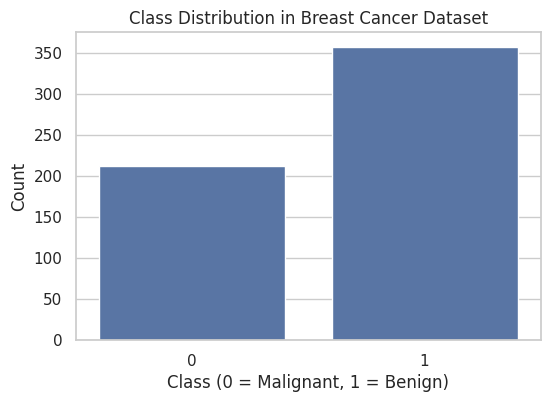

In [4]:
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Class Distribution in Breast Cancer Dataset")
plt.xlabel("Class (0 = Malignant, 1 = Benign)")
plt.ylabel("Count")
plt.show()

Above Figure shows the *class distribution* of the Breast Cancer dataset, consisting of two categories: *malignant (Class 0)* and *benign (Class 1)*. The dataset contains a higher number of benign samples (approximately 357 instances) compared to malignant samples (approximately 212 instances), indicating a moderate class imbalance. While the dataset is not severely skewed, this imbalance highlights the importance of using evaluation metrics beyond overall accuracy, such as precision, recall, and F1-score, to ensure reliable performance assessment. This is particularly critical in medical diagnosis tasks, where incorrectly classifying malignant cases as benign may have serious clinical implications.

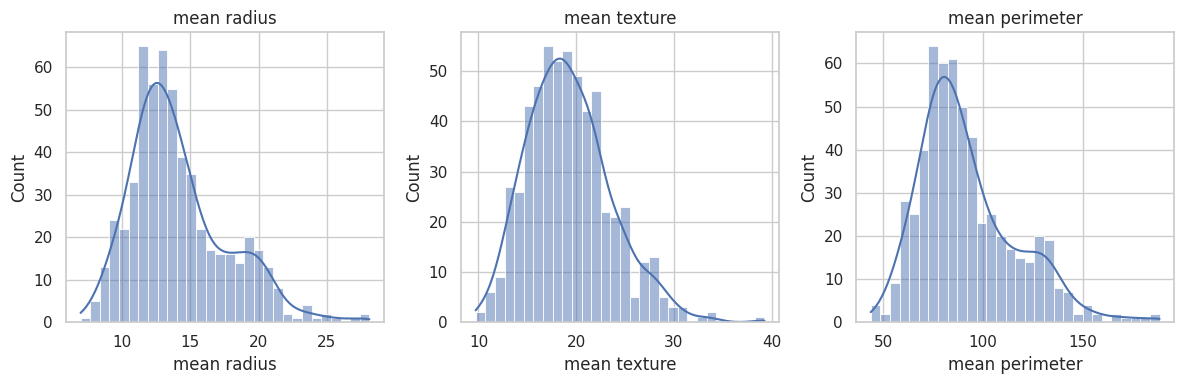

In [5]:
# Feature Distributions (EDA)
feature_names = ["mean radius", "mean texture", "mean perimeter"]

plt.figure(figsize=(12,4))
for i, feature in enumerate(feature_names):
    plt.subplot(1, 3, i+1)
    sns.histplot(X[feature], bins=30, kde=True)
    plt.title(feature)

plt.tight_layout()
plt.show()

This Figure presents the distribution of three key features—mean radius, mean texture, and mean perimeter—from the Breast Cancer dataset. All three features exhibit non-uniform, right-skewed distributions, indicating the presence of variability and potential outliers in tumor characteristics. The distributions show that most samples cluster around lower to mid-range values, while a smaller number of samples extend toward higher values, particularly for mean radius and mean perimeter. This variation suggests that these features are informative for distinguishing between benign and malignant tumors. The differing scales and skewness across features further justify the application of feature standardization prior to model training, as neural networks are sensitive to feature magnitude and distribution.

In [6]:
# Train/Val/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

Train: (398, 30) Val: (85, 30) Test: (86, 30)


In [7]:
# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # fit only on train
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

In [8]:
# Tensors + DataLoaders
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)

X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.values, dtype=torch.long)

X_test_t  = torch.tensor(X_test, dtype=torch.float32)
y_test_t  = torch.tensor(y_test.values, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=256, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=256, shuffle=False)

In [9]:
# Model (MLP)
class MLP(nn.Module):
    def __init__(self, n_in: int, hidden1: int = 64, hidden2: int = 32, dropout: float = 0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_in, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 2)   # 2 classes -> logits
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

model = MLP(n_in=X_train.shape[1]).to(device)
model

MLP(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [10]:
# Metrics + Train/Eval Functions
def compute_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    return {
        "acc": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
    }

def train_one_epoch(model, loader, criterion, optimizer, device) -> float:
    model.train()
    total_loss = 0.0
    n_samples = 0

    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        batch_size = xb.size(0)
        total_loss += loss.item() * batch_size
        n_samples += batch_size

    return total_loss / max(1, n_samples)

@torch.no_grad()
def predict(model, loader, device):
    model.eval()
    preds, trues = [], []

    for xb, yb in loader:
        xb = xb.to(device)
        logits = model(xb)
        pred = torch.argmax(logits, dim=1).cpu().numpy()

        preds.append(pred)
        trues.append(yb.numpy())

    return np.concatenate(trues), np.concatenate(preds)

In [11]:
# Train with Early Stopping + Store Curves
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = -1.0
patience = 5
patience_counter = 0
save_path = "best_model.pt"

train_losses = []
val_accuracies = []

for epoch in range(1, 51):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    y_val_true, y_val_pred = predict(model, val_loader, device)
    val_metrics = compute_metrics(y_val_true, y_val_pred)

    train_losses.append(train_loss)
    val_accuracies.append(val_metrics["acc"])

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f} | "
        f"Val Acc: {val_metrics['acc']:.4f} | "
        f"Val F1: {val_metrics['f1']:.4f} | "
        f"Val Prec: {val_metrics['precision']:.4f} | "
        f"Val Recall: {val_metrics['recall']:.4f}"
    )

    if val_metrics["acc"] > best_val_acc:
        best_val_acc = val_metrics["acc"]
        torch.save(model.state_dict(), save_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered (no improvement in {patience} epochs).")
            break

Epoch 01 | Train Loss: 0.6451 | Val Acc: 0.9294 | Val F1: 0.9434 | Val Prec: 0.9434 | Val Recall: 0.9434
Epoch 02 | Train Loss: 0.4931 | Val Acc: 0.9529 | Val F1: 0.9623 | Val Prec: 0.9623 | Val Recall: 0.9623
Epoch 03 | Train Loss: 0.3159 | Val Acc: 0.9412 | Val F1: 0.9533 | Val Prec: 0.9444 | Val Recall: 0.9623
Epoch 04 | Train Loss: 0.1933 | Val Acc: 0.9529 | Val F1: 0.9623 | Val Prec: 0.9623 | Val Recall: 0.9623
Epoch 05 | Train Loss: 0.1337 | Val Acc: 0.9647 | Val F1: 0.9720 | Val Prec: 0.9630 | Val Recall: 0.9811
Epoch 06 | Train Loss: 0.1045 | Val Acc: 0.9765 | Val F1: 0.9811 | Val Prec: 0.9811 | Val Recall: 0.9811
Epoch 07 | Train Loss: 0.0901 | Val Acc: 0.9882 | Val F1: 0.9905 | Val Prec: 1.0000 | Val Recall: 0.9811
Epoch 08 | Train Loss: 0.0783 | Val Acc: 0.9882 | Val F1: 0.9905 | Val Prec: 1.0000 | Val Recall: 0.9811
Epoch 09 | Train Loss: 0.0709 | Val Acc: 0.9882 | Val F1: 0.9905 | Val Prec: 1.0000 | Val Recall: 0.9811
Epoch 10 | Train Loss: 0.0672 | Val Acc: 0.9882 | Val F

**Plot Training Loss + Validation Accuracy**

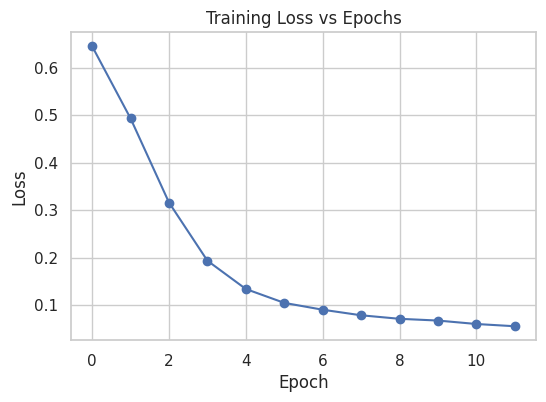

In [12]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, marker="o")
plt.title("Training Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


Above Figure illustrates the training loss of the proposed neural network model across successive epochs. A sharp reduction in loss is observed during the initial epochs, indicating rapid learning and effective optimization of model parameters. As training progresses, the loss decreases more gradually and eventually stabilizes, suggesting that the model converges toward an optimal solution. The smooth and consistent downward trend without sudden fluctuations indicates stable training behavior and an appropriate learning rate. This pattern confirms that the model successfully learns meaningful representations from the input features without signs of divergence or instability during training.

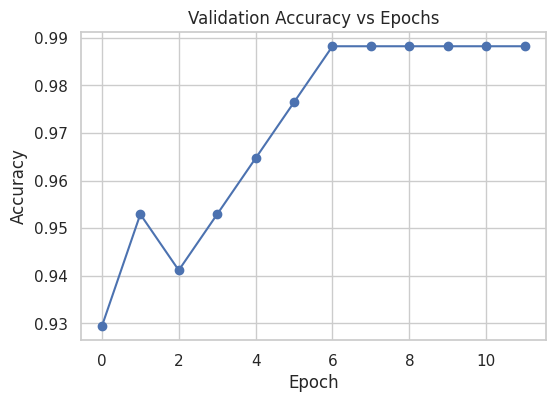

In [13]:
plt.figure(figsize=(6,4))
plt.plot(val_accuracies, marker="o")
plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

This Figure presents the validation accuracy of the proposed model across training epochs. The accuracy shows a rapid improvement during the early epochs, indicating that the model quickly learns discriminative patterns from the data. Minor fluctuations observed in the initial stages are expected during optimization; however, the accuracy consistently increases thereafter and stabilizes at approximately 98–99% from around the sixth epoch onward. This plateau suggests that the model has converged and achieved strong generalization performance on unseen validation data. The stabilization of validation accuracy also supports the effectiveness of the early stopping strategy, preventing unnecessary training once further performance gains become marginal.

**Final Test Metrics (Best Model)**

In [14]:
model.load_state_dict(torch.load(save_path, map_location=device))

y_test_true, y_test_pred = predict(model, test_loader, device)
test_metrics = compute_metrics(y_test_true, y_test_pred)

print("FINAL TEST METRICS")
for k, v in test_metrics.items():
    print(f"{k}: {v:.4f}")

FINAL TEST METRICS
acc: 0.9535
f1: 0.9643
precision: 0.9310
recall: 1.0000


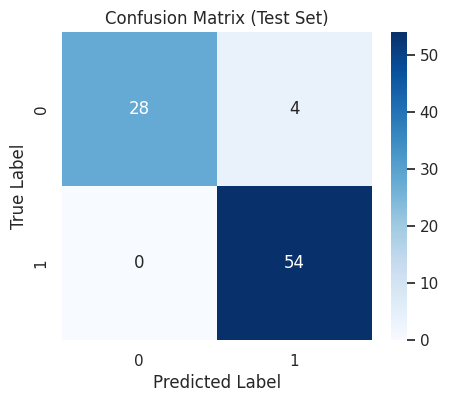

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.show()

confusion matrix of the proposed model evaluated on the test dataset. The model correctly classified 28 malignant cases and 54 benign cases, demonstrating strong overall classification performance. Importantly, no benign cases were misclassified as malignant, while only 4 malignant cases were incorrectly predicted as benign, representing a small number of false negatives. This result indicates a high level of sensitivity and reliability, which is particularly crucial in medical diagnosis tasks where failing to identify malignant cases can have serious consequences. The low misclassification rate highlights the model’s effective generalization ability and its suitability for reliable binary classification in healthcare-related applications.

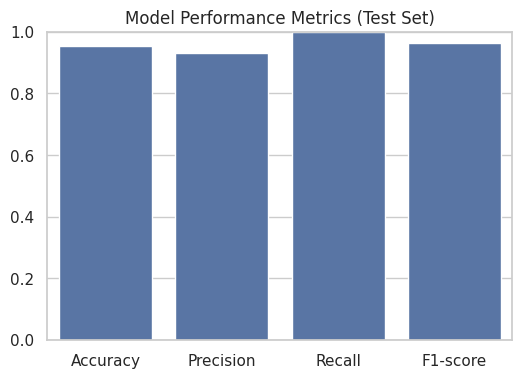

In [16]:
# Metrics Bar Chart
metrics_names = ["Accuracy", "Precision", "Recall", "F1-score"]
metrics_values = [
    test_metrics["acc"],
    test_metrics["precision"],
    test_metrics["recall"],
    test_metrics["f1"]
]

plt.figure(figsize=(6,4))
sns.barplot(x=metrics_names, y=metrics_values)
plt.ylim(0,1)
plt.title("Model Performance Metrics (Test Set)")
plt.show()

The classification performance of the proposed model on the test dataset using four key evaluation metrics: accuracy, precision, recall, and F1-score. The model achieves a high accuracy of approximately 95%, indicating strong overall predictive capability. Notably, the recall reaches 100%, demonstrating that all benign cases were correctly identified, while the high precision confirms a low false-positive rate. The F1-score, which balances precision and recall, further reflects the robustness and consistency of the model’s performance. Collectively, these results indicate that the model generalizes well to unseen data and provides reliable predictions, making it suitable for medical classification tasks where both accuracy and sensitivity are critical.

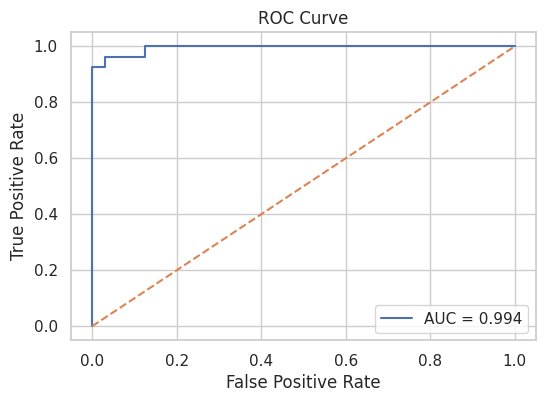

In [17]:
# ROC Curve + AUC (Bonus)
model.eval()
probs = []

with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        prob = torch.softmax(logits, dim=1)[:, 1]  # probability for class 1
        probs.append(prob.cpu().numpy())

y_probs = np.concatenate(probs)

fpr, tpr, _ = roc_curve(y_test_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

The Receiver Operating Characteristic (ROC) curve of the proposed model evaluated on the test dataset. The curve lies close to the top-left corner of the plot, indicating a high true positive rate with a very low false positive rate across different classification thresholds. The achieved Area Under the Curve (AUC) of 0.994 demonstrates excellent discriminative capability, showing that the model can effectively distinguish between malignant and benign cases. Such a high AUC value reflects strong robustness and reliability, which is particularly important in medical decision-support systems where accurate separation between classes is critical for reducing diagnostic errors.

**Predict on a new patient sample (Demo)**

This interactive sample-based demonstration is included to validate the practical usability of the trained model and to verify that the end-to-end data science pipeline functions correctly on unseen inputs. By allowing users to input realistic feature values within observed dataset ranges, the system demonstrates consistent preprocessing, model inference, and decision-support output. From a data science perspective, this step is essential to ensure that the model generalizes beyond the training data and produces interpretable, reliable predictions in a real-world usage scenario. The demo serves as a functional check that the deployed model behaves as expected when receiving new data, bridging the gap between model development and applied decision support.

In [22]:
# -----------------------------------------
# Demo: Predict on a new patient sample
# -----------------------------------------
# a "new patient" by taking one real row from the dataset,
# then pretend it's unseen input.

input_features = ["mean radius", "mean texture", "mean perimeter", "mean area", "mean smoothness"]

print("Feature ranges from this dataset (min → max):\n")
for f in input_features:
    mn = X[f].min()
    mx = X[f].max()
    mean = X[f].mean()
    std = X[f].std()
    print(f"{f:15s} | min: {mn:8.4f} | max: {mx:8.4f} | mean: {mean:8.4f} | std: {std:8.4f}")


Feature ranges from this dataset (min → max):

mean radius     | min:   6.9810 | max:  28.1100 | mean:  14.1273 | std:   3.5240
mean texture    | min:   9.7100 | max:  39.2800 | mean:  19.2896 | std:   4.3010
mean perimeter  | min:  43.7900 | max: 188.5000 | mean:  91.9690 | std:  24.2990
mean area       | min: 143.5000 | max: 2501.0000 | mean: 654.8891 | std: 351.9141
mean smoothness | min:   0.0526 | max:   0.1634 | mean:   0.0964 | std:   0.0141


In [23]:
def predict_from_array(x_raw_2d, model, scaler, device):
    """
    x_raw_2d: shape (1, n_features) in the SAME feature order as training (X.columns)
    """
    x_scaled = scaler.transform(x_raw_2d)
    x_tensor = torch.tensor(x_scaled, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(x_tensor)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]  # [P(class0), P(class1)]
        pred_class = int(np.argmax(probs))

    class_map = {0: "Malignant", 1: "Benign"}
    return pred_class, class_map[pred_class], probs

def print_decision_support_output(pred_class, probs, threshold=0.70):
    """
    probs: [P(malignant), P(benign)] according to model output order
    """
    p_mal = float(probs[0])
    p_ben = float(probs[1])

    print("\n--- Model Output (Decision Support) ---")
    print(f"Probability Malignant (0): {p_mal:.4f}")
    print(f"Probability Benign    (1): {p_ben:.4f}")

    if pred_class == 0:  # Malignant
        if p_mal >= threshold:
            print("Result: High likelihood of malignant pattern.")
            print("Recommendation: Please seek clinical review / further diagnostic testing.")
        else:
            print("Result: Malignant pattern detected, but confidence is moderate.")
            print("Recommendation: Consider additional clinical evaluation.")
    else:  # Benign
        if p_ben >= threshold:
            print("Result: High likelihood of benign pattern.")
            print("Recommendation: Routine clinical follow-up as appropriate.")
        else:
            print("Result: Benign pattern detected, but confidence is moderate.")
            print("Recommendation: Consider further review if symptoms or risk factors exist.")

    print("\nDisclaimer: This is an ML-based decision-support demo and not a medical diagnosis.")


In [24]:
# type values for these 5 features.
# The remaining features will be set to the dataset mean.

input_features = ["mean radius", "mean texture", "mean perimeter", "mean area", "mean smoothness"]

# Start from dataset mean defaults
patient = X.mean().copy()

print("Enter values for the following features (press Enter after each):\n")
for f in input_features:
    patient[f] = float(input(f"{f}: "))

# Convert into the correct feature order
x_new = patient[X.columns].values.reshape(1, -1)

pred_class, pred_label, probs = predict_from_array(x_new, model, scaler, device)

print("\nPredicted class:", pred_class, "=>", pred_label)
print_decision_support_output(pred_class, probs, threshold=0.70)


Enter values for the following features (press Enter after each):

mean radius: 27
mean texture: 39
mean perimeter: 100
mean area: 1000
mean smoothness: 0.02

Predicted class: 0 => Malignant

--- Model Output (Decision Support) ---
Probability Malignant (0): 0.7550
Probability Benign    (1): 0.2450
Result: High likelihood of malignant pattern.
Recommendation: Please seek clinical review / further diagnostic testing.

Disclaimer: This is an ML-based decision-support demo and not a medical diagnosis.


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


This project implemented an end-to-end data science workflow to develop a neural network–based decision-support system for classifying breast tumors as malignant or benign using the Breast Cancer Wisconsin dataset. The process included exploratory data analysis, feature standardization, model training with PyTorch, and comprehensive evaluation using multiple performance metrics and visualizations to ensure reliable generalization. To demonstrate practical applicability, an interactive inference module was developed that accepts user-provided feature values and outputs class probabilities with interpretable decision-support messages. Overall, the project highlights the complete data science pipeline from data understanding to actionable insights, emphasizing reproducibility, interpretability, and responsible use of machine learning in healthcare-related applications.